In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, AveragePooling2D, Input
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import plot_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-12-22 11:03:37.710450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 11:03:39.129090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734840219.674048    4364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734840219.833528    4364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 11:03:41.162304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

modules loaded


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### EDA ------------------------

In [3]:
data_dir = 'dataset/PlantVillage'
ds_name = 'PlantVillage'

In [4]:
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [5]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df

df = create_df(filepaths, labels)

In [6]:
df.head()

filepaths              labels
0  dataset/PlantVillage/Apple___Apple_scab/image ...  Apple___Apple_scab
1  dataset/PlantVillage/Apple___Apple_scab/image ...  Apple___Apple_scab
2  dataset/PlantVillage/Apple___Apple_scab/image ...  Apple___Apple_scab
3  dataset/PlantVillage/Apple___Apple_scab/image ...  Apple___Apple_scab
4  dataset/PlantVillage/Apple___Apple_scab/image ...  Apple___Apple_scab

In [7]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)

The PlantVillage dataset has 24626 images.


In [8]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The PlantVillage dataset has: 

Class 'Apple___Apple_scab' has 630 images
----------------------------------------------------------------------
Class 'Apple___Black_rot' has 621 images
----------------------------------------------------------------------
Class 'Apple___Cedar_apple_rust' has 275 images
----------------------------------------------------------------------
Class 'Apple___healthy' has 1645 images
----------------------------------------------------------------------
Class 'Background_without_leaves' has 1143 images
----------------------------------------------------------------------
Class 'Potato___Early_blight' has 1000 images
----------------------------------------------------------------------
Class 'Potato___healthy' has 152 images
----------------------------------------------------------------------
Class 'Potato___Late_blight' has 1000 images
----------------------------------------------------------------------
Class 'Tomato___Bacterial_spot' has 2127 images


In [9]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The PlantVillage dataset has 18 classes


In [10]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.6, shuffle= True, random_state= 42)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.4, shuffle= True, random_state= 42)

In [11]:
def num_imgs(df, name='df'):
    print(f"Number of {name} dataset is {len(df)} images")

num_imgs(train_df, 'Training '+ds_name)
num_imgs(valid_df, 'Validation '+ds_name)
num_imgs(test_df, 'Testing '+ds_name)

Number of Training PlantVillage dataset is 14775 images
Number of Validation PlantVillage dataset is 3940 images
Number of Testing PlantVillage dataset is 5911 images


In [12]:
max_samples = train_df['labels'].value_counts().max() // 2

def oversample_dataframe(df, target_column, n_samples, random_state=42):
    df_list = []
    for label in df[target_column].unique():
        df_class = df[df[target_column] == label]
        df_over = resample(df_class, 
                           replace=True, 
                           n_samples=n_samples, 
                           random_state=random_state)
        df_list.append(df_over)
    return pd.concat(df_list)

train_df = oversample_dataframe(train_df, 'labels', max_samples)

In [13]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training PlantVillage dataset has 18 classes
The Validation PlantVillage dataset has 18 classes
The Testing PlantVillage dataset has 18 classes


In [14]:
classes_count(train_df, 'Training '+ds_name)

The Training PlantVillage dataset has: 

Class 'Tomato___Late_blight' has 1616 images
----------------------------------------------------------------------
Class 'Potato___Late_blight' has 1616 images
----------------------------------------------------------------------
Class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' has 1616 images
----------------------------------------------------------------------
Class 'Tomato___healthy' has 1616 images
----------------------------------------------------------------------
Class 'Tomato___Septoria_leaf_spot' has 1616 images
----------------------------------------------------------------------
Class 'Apple___Apple_scab' has 1616 images
----------------------------------------------------------------------
Class 'Tomato___Early_blight' has 1616 images
----------------------------------------------------------------------
Class 'Tomato___Bacterial_spot' has 1616 images
----------------------------------------------------------------------
Class 'A

In [15]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation PlantVillage dataset has: 

Class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' has 858 images
----------------------------------------------------------------------
Class 'Tomato___Late_blight' has 308 images
----------------------------------------------------------------------
Class 'Apple___healthy' has 257 images
----------------------------------------------------------------------
Class 'Tomato___Target_Spot' has 225 images
----------------------------------------------------------------------
Class 'Tomato___Septoria_leaf_spot' has 276 images
----------------------------------------------------------------------
Class 'Potato___Early_blight' has 156 images
----------------------------------------------------------------------
Class 'Tomato___Early_blight' has 161 images
----------------------------------------------------------------------
Class 'Tomato___healthy' has 246 images
----------------------------------------------------------------------
Class 'Apple___Ceda

In [16]:
classes_count(test_df, 'Testing '+ds_name)

The Testing PlantVillage dataset has: 

Class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' has 1266 images
----------------------------------------------------------------------
Class 'Tomato___Septoria_leaf_spot' has 433 images
----------------------------------------------------------------------
Class 'Tomato___Spider_mites Two-spotted_spider_mite' has 366 images
----------------------------------------------------------------------
Class 'Tomato___Late_blight' has 457 images
----------------------------------------------------------------------
Class 'Potato___Late_blight' has 235 images
----------------------------------------------------------------------
Class 'Apple___Apple_scab' has 152 images
----------------------------------------------------------------------
Class 'Tomato___Bacterial_spot' has 553 images
----------------------------------------------------------------------
Class 'Tomato___Early_blight' has 244 images
----------------------------------------------------------

#### Data Generator

In [17]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    img = preprocess_input(img)
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                            rotation_range=5,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False
                            )

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepaths', 
                                       y_col= 'labels', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= False, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 29088 validated image filenames belonging to 18 classes.
Found 3940 validated image filenames belonging to 18 classes.
Found 5911 validated image filenames belonging to 18 classes.


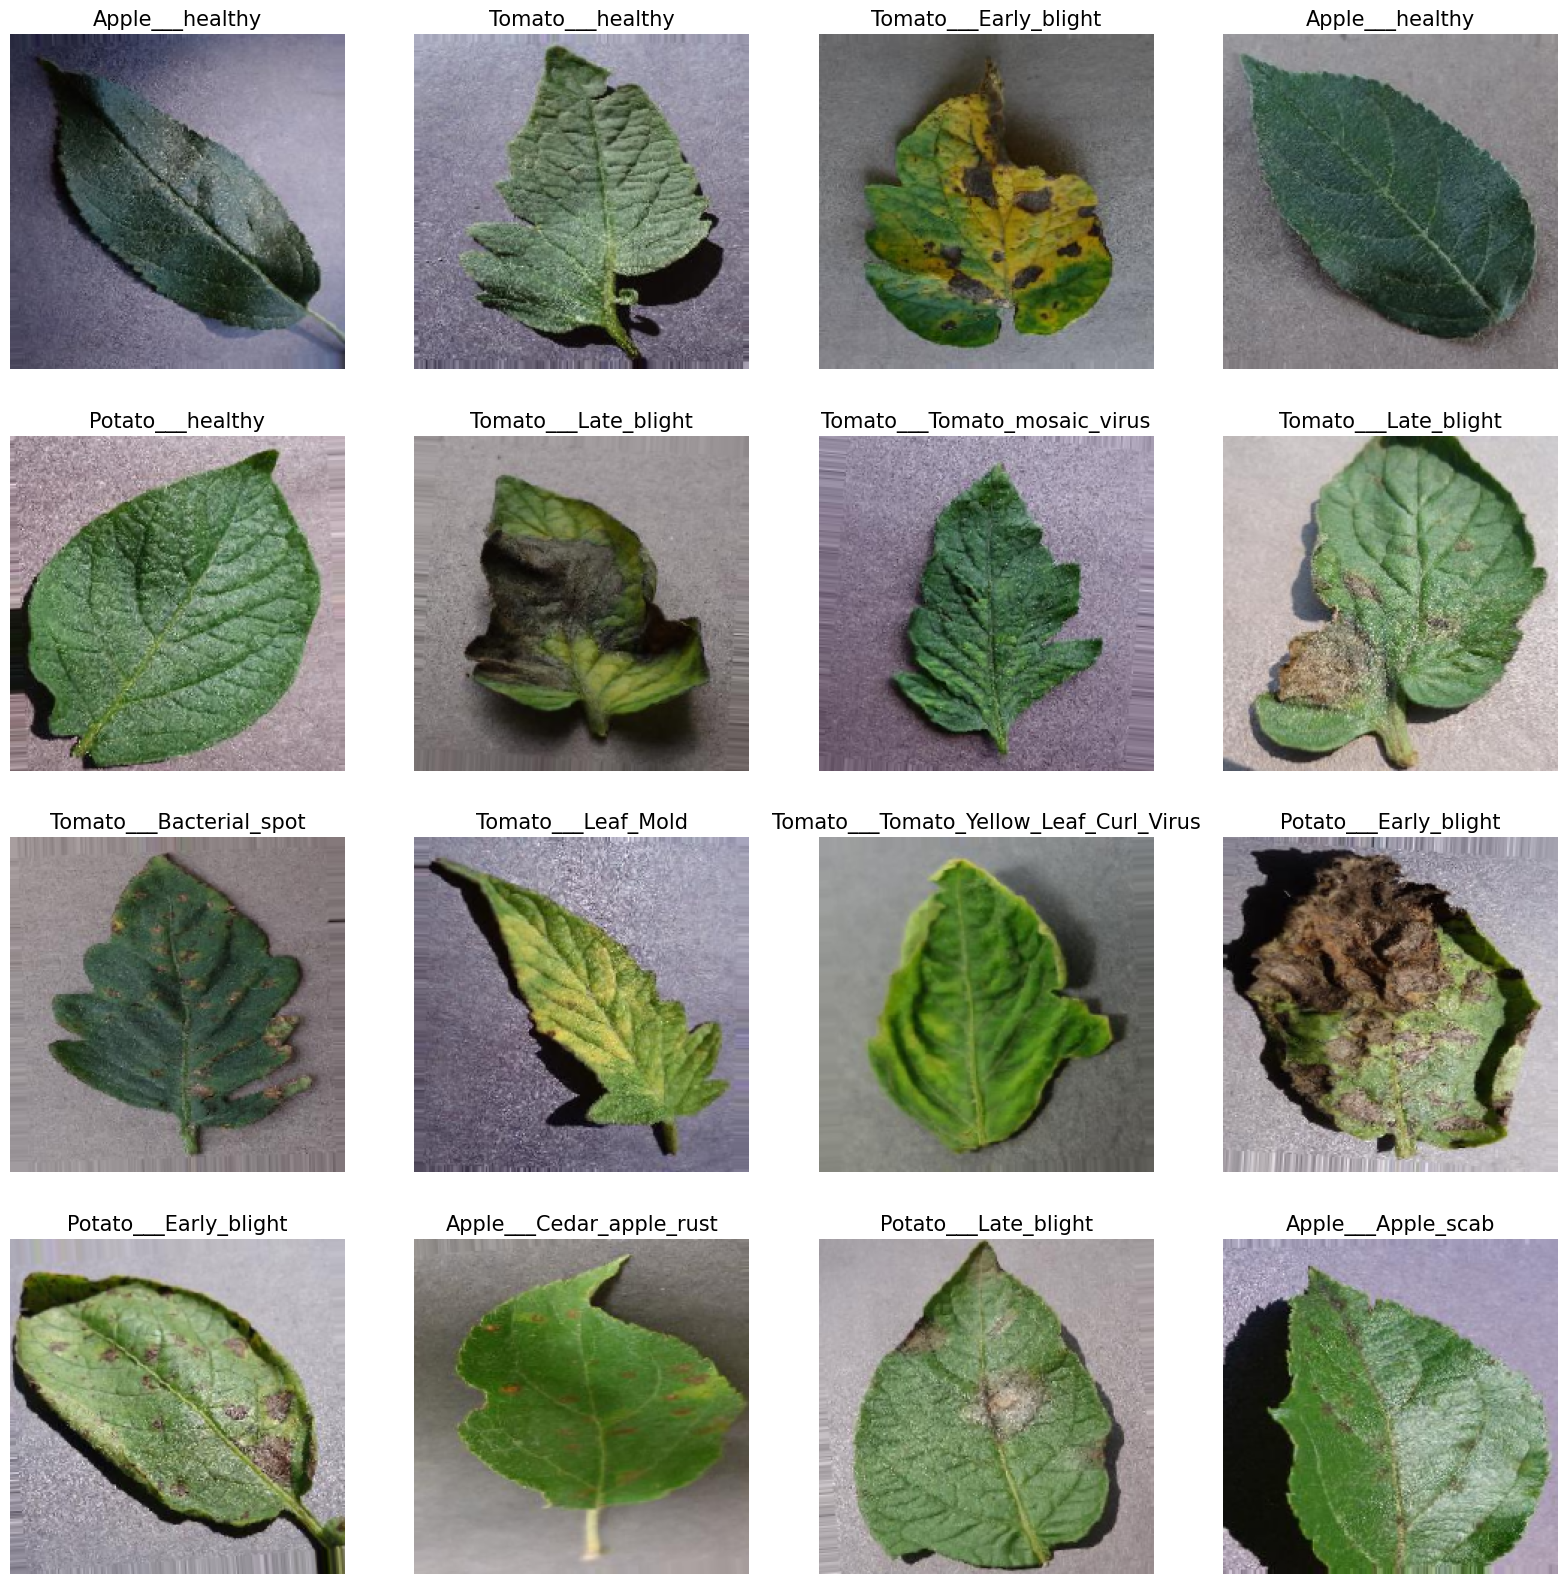

In [18]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0      # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')
    
plt.show()

### Model Structure ------------------------

In [19]:
# Create Model Structure
# input_tensor = Input(batch_shape=(None, 224, 224, 3))  # Tambahkan batch_shape
input_tensor = Input(shape=(224, 224, 3)) 
class_count = len(list(train_gen.class_indices.keys()))

In [20]:
base_model = MobileNetV3Large(
    weights='imagenet', 
    include_top=False,
    pooling=None,
    # input_shape=(224,224,3)
    input_tensor = input_tensor
)

I0000 00:00:1734840272.417454    4364 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, AdamW
from tensorflow.keras.regularizers import l2

x = base_model.output

x = Dense(1028, activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dense(514, activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Flatten()(x)

x = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

In [22]:
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'f1_score'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 4,522,436 (17.25 MB)

 Trainable params: 4,498,036 (17.16 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
Physical devices cannot be modified after being initialized


In [ ]:
epochs = 20  # number of all epochs in training

history = model.fit(
    x=train_gen,
    epochs = epochs,
    verbose = 1,
    validation_data = valid_gen, 
    validation_steps = None,
    shuffle = False,
    batch_size = batch_size,
)

Epoch 1/20


I0000 00:00:1734840288.930585    4433 service.cc:148] XLA service 0x7fedb8003690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734840288.930815    4433 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-22 11:04:49.386200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734840291.078879    4433 cuda_dnn.cc:529] Loaded cuDNN version 90501
2024-12-22 11:04:52.638330: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 36 bytes spill stores, 36 bytes spill loads

2024-12-22 11:04:52.640600: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 516 bytes spill st

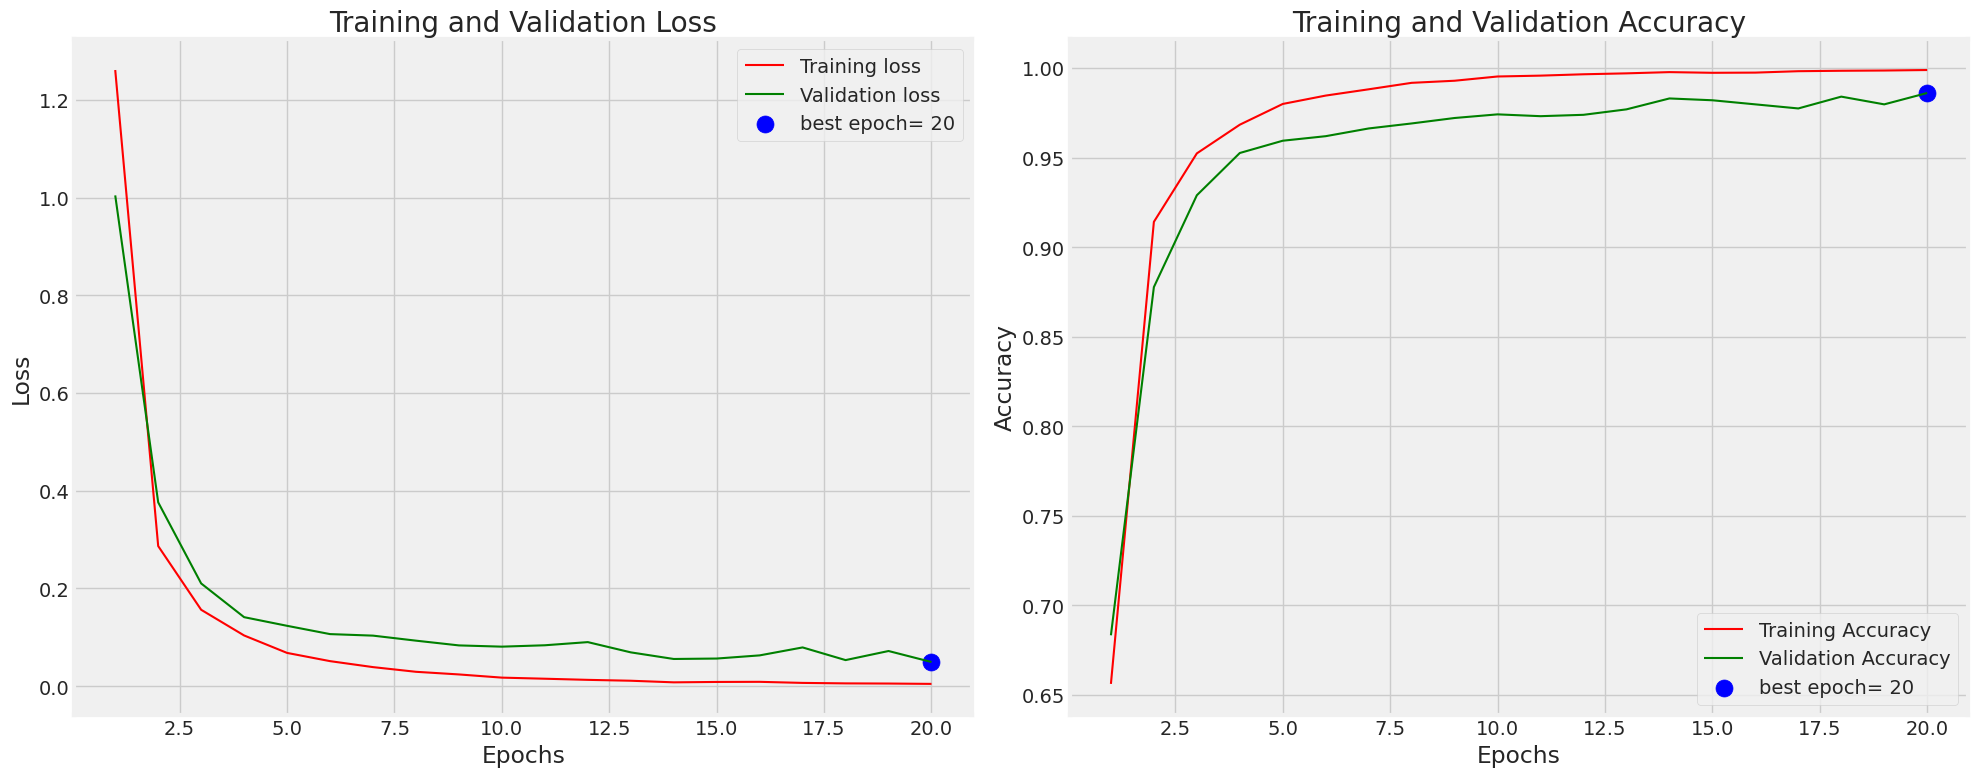

In [25]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=1.5)  # Thinner line
plt.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=1.5)  # Thinner line
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=1.5)  # Thinner line
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=1.5)  # Thinner line
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

257/257 ━━━━━━━━━━━━━━━━━━━━ 50s 195ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 3.0455e-04
257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9857 - f1_score: 0.9830 - loss: 0.0489 


2024-12-22 09:51:24.737325: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 20 bytes spill stores, 20 bytes spill loads

2024-12-22 09:51:24.939072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 176 bytes spill stores, 176 bytes spill loads

2024-12-22 09:51:25.133734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-12-22 09:51:25.183765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 32 bytes spill stores, 32 bytes spill loads

2024-12-22 09:51:25.261976: I external/local_xla/xla/stream_executor/cud

257/257 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.9865 - f1_score: 0.9828 - loss: 0.0609
Train Loss:  0.00037867127684876323
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04922742024064064
Validation Accuracy:  0.9860405921936035
--------------------
Test Loss:  0.05697742477059364
Test Accuracy:  0.9854508638381958


In [27]:
post_train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepaths', 
                                       y_col= 'labels', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= False, 
                                       batch_size=batch_size)

post_valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= False, 
                                       batch_size= batch_size)

train_preds = model.predict(post_train_gen)
train_y_pred = np.argmax(train_preds, axis=1)

val_preds = model.predict(post_valid_gen)
val_y_pred = np.argmax(val_preds, axis=1)

Found 29088 validated image filenames belonging to 18 classes.
Found 3940 validated image filenames belonging to 18 classes.
909/909 ━━━━━━━━━━━━━━━━━━━━ 173s 187ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step


In [28]:

def plot_confusion_matrix(cm, classes, title, ax):
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], horizontalalignment='center', 
                color='white' if cm[i, j] > thresh else 'black')

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

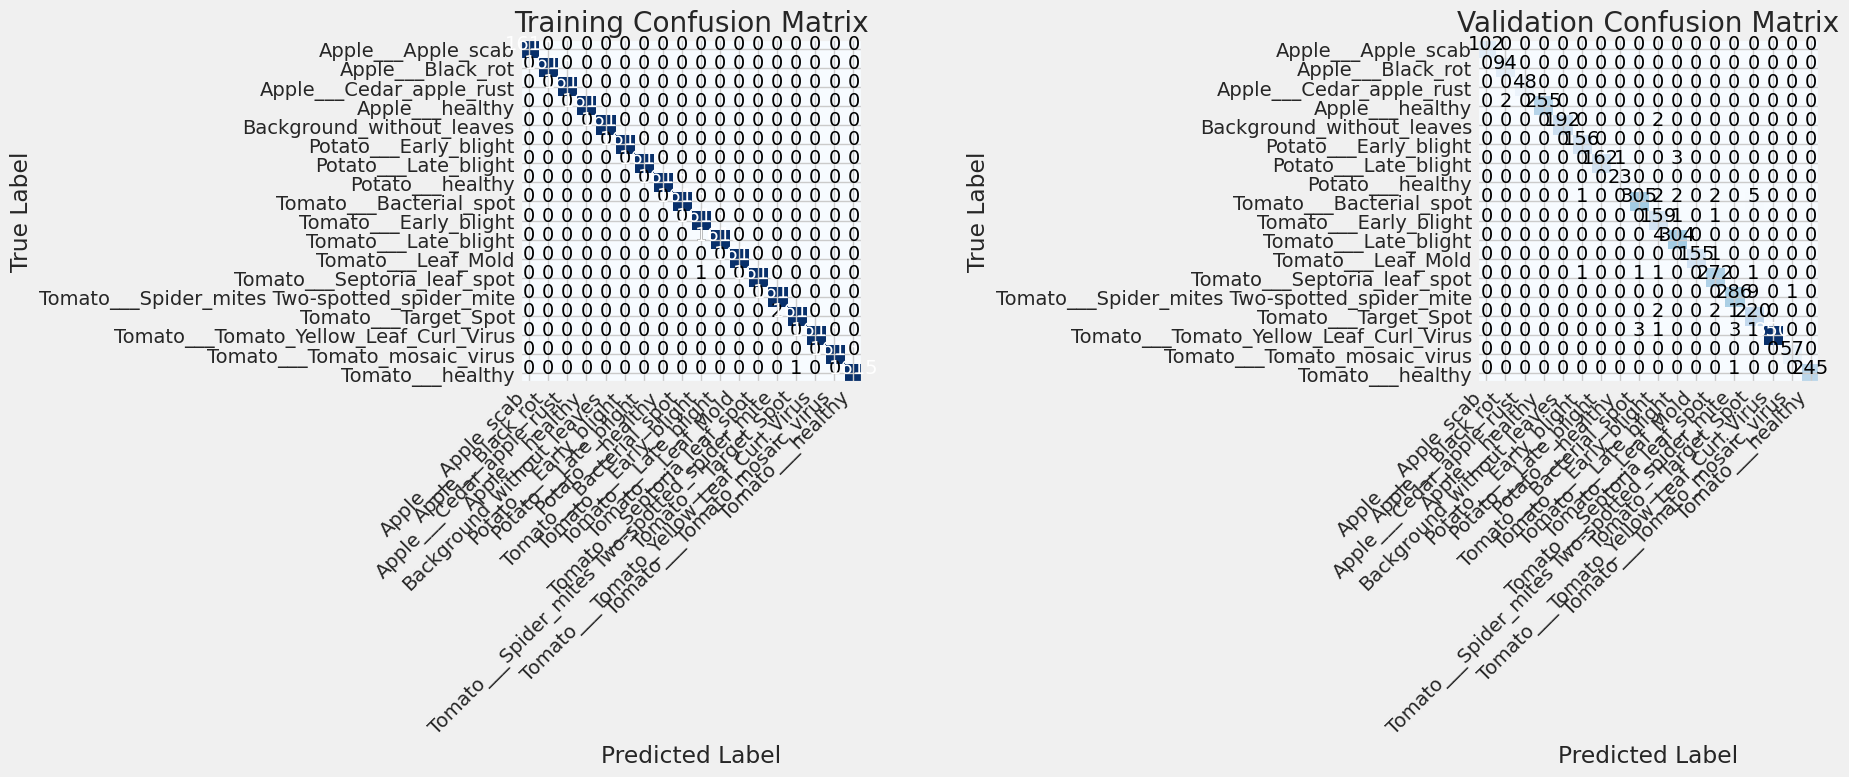

In [ ]:
train_cm = confusion_matrix(train_gen.classes, train_y_pred)
val_cm = confusion_matrix(valid_gen.classes, val_y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

plot_confusion_matrix(train_cm, classes, 'Training Confusion Matrix', ax1)
plot_confusion_matrix(val_cm, classes, 'Validation Confusion Matrix', ax2)

plt.tight_layout()
plt.show()

In [30]:
print(classification_report(post_valid_gen.classes, val_y_pred, target_names= classes))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       102
                            Apple___Black_rot       0.98      1.00      0.99        94
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        48
                              Apple___healthy       1.00      0.99      1.00       257
                    Background_without_leaves       1.00      0.99      0.99       194
                        Potato___Early_blight       0.99      1.00      0.99       156
                         Potato___Late_blight       1.00      0.98      0.99       166
                             Potato___healthy       0.96      1.00      0.98        23
                      Tomato___Bacterial_spot       0.99      0.96      0.97       317
                        Tomato___Early_blight       0.93      0.99      0.96       161
                         Tomato___Late_bli

In [31]:
print(classification_report(post_train_gen.classes, train_y_pred, target_names= classes))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00      1616
                            Apple___Black_rot       1.00      1.00      1.00      1616
                     Apple___Cedar_apple_rust       1.00      1.00      1.00      1616
                              Apple___healthy       1.00      1.00      1.00      1616
                    Background_without_leaves       1.00      1.00      1.00      1616
                        Potato___Early_blight       1.00      1.00      1.00      1616
                         Potato___Late_blight       1.00      1.00      1.00      1616
                             Potato___healthy       1.00      1.00      1.00      1616
                      Tomato___Bacterial_spot       1.00      1.00      1.00      1616
                        Tomato___Early_blight       1.00      1.00      1.00      1616
                         Tomato___Late_bli

### TEST ------------------------

In [32]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step


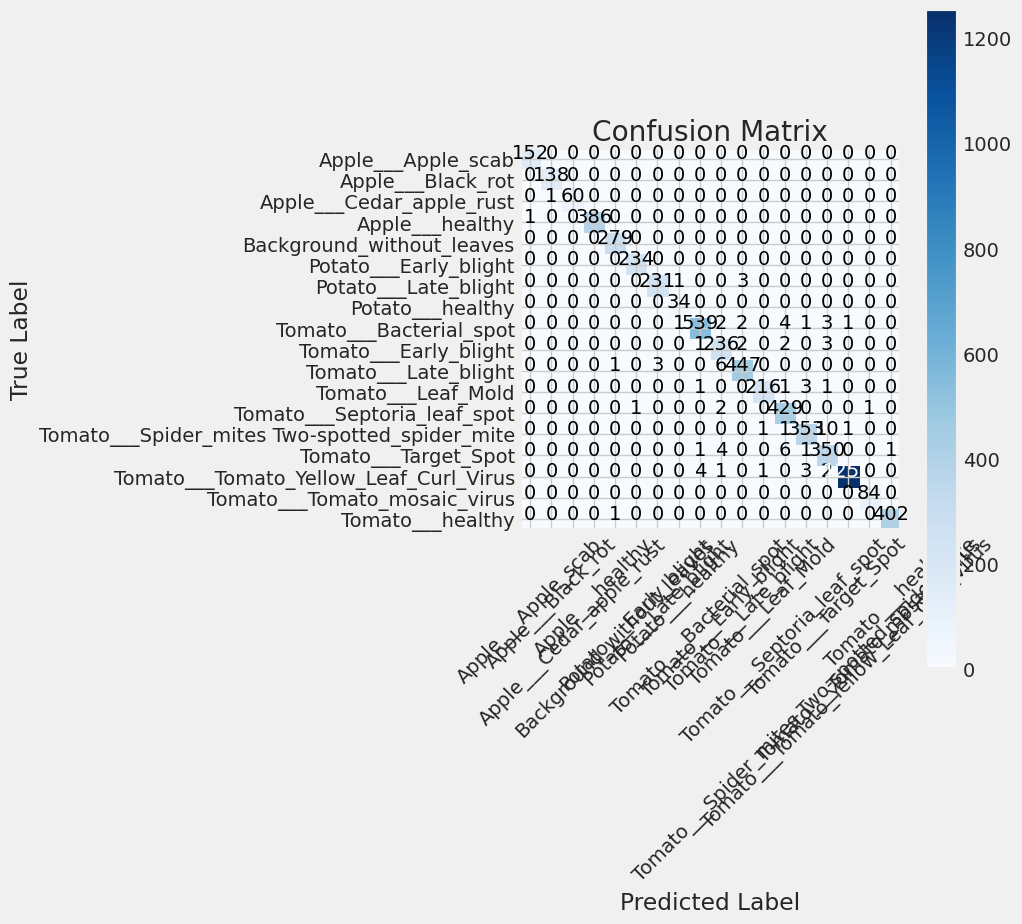

In [33]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [34]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      1.00      1.00       152
                            Apple___Black_rot       0.99      1.00      1.00       138
                     Apple___Cedar_apple_rust       1.00      0.98      0.99        61
                              Apple___healthy       1.00      1.00      1.00       387
                    Background_without_leaves       0.99      1.00      1.00       279
                        Potato___Early_blight       1.00      1.00      1.00       234
                         Potato___Late_blight       0.99      0.98      0.99       235
                             Potato___healthy       0.94      1.00      0.97        34
                      Tomato___Bacterial_spot       0.99      0.97      0.98       553
                        Tomato___Early_blight       0.94      0.97      0.95       244
                         Tomato___Late_bli

In [35]:
model.save('pre_trained_model/MobileNetV3_PlantVillage_updated_v3.h5')
model.save('pre_trained_model/MobileNetV3_PlantVillage_updated_v3.keras')